In [2]:
# Importing necessary libraries
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical


In [3]:
# Set file paths (Update these paths as per your system)
gunshot_folder = 'C:/Users/aadit/Downloads/archive/balance/gunshot'
no_gunshot_folder = 'C:/Users/aadit/Downloads/archive/balance/no_gunshot'
gunshot_label_csv = 'C:/Users/aadit/Downloads/archive/gunshot_labels.csv'
no_gunshot_label_csv = 'C:/Users/aadit/Downloads/archive/no_gunshot_labels.csv'
epoch_folder = 'C:/Users/aadit/Downloads/archive/epoch'


In [4]:
# Load audio files
def load_audio_files(folder):
    audio_files = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder, file_name)
            audio_files.append(file_path)
    return audio_files

gunshot_files = load_audio_files(gunshot_folder)
no_gunshot_files = load_audio_files(no_gunshot_folder)

# Combine and shuffle data
audio_files = gunshot_files + no_gunshot_files
labels = [1] * len(gunshot_files) + [0] * len(no_gunshot_files)

data = list(zip(audio_files, labels))
random.shuffle(data)
audio_files, labels = zip(*data)


In [5]:
# Extract features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs.T  # Transpose to get shape (time_steps, features)

features = [extract_features(file_path) for file_path in audio_files]
features = np.array(features)
features = np.expand_dims(features, axis=-1)  # Add channel dimension


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)


In [10]:
# Define the model
def create_1d_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Dropout(0.25),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.25),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
model = create_1d_cnn_model(input_shape)


In [11]:
# Set up checkpoint to save the best model
checkpoint = ModelCheckpoint(os.path.join(epoch_folder, 'model_checkpoint.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6243 - loss: 11.2674 - val_accuracy: 0.8852 - val_loss: 0.3530
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8347 - loss: 0.8812 - val_accuracy: 0.9245 - val_loss: 0.2372
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8547 - loss: 0.4486 - val_accuracy: 0.9456 - val_loss: 0.2068
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9051 - loss: 0.2685 - val_accuracy: 0.9547 - val_loss: 0.1817
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9125 - loss: 0.2196 - val_accuracy: 0.9668 - val_loss: 0.1569
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9318 - loss: 0.2010 - val_accuracy: 0.9668 - val_loss: 0.1217
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9345 - loss: 0.1640 - val_accuracy: 0.9758 - val_loss: 0.1132
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9432 - loss: 0.1454 - val_accuracy: 0.9758 - 

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the final model
model.save(os.path.join(epoch_folder, 'final_model.keras'))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9810 - loss: 0.0652 
Test Accuracy: 97.58%


In [18]:
#from keras.models import load_model[Load Saved Model ]

# Load the saved checkpoint model
#checkpoint_path = os.path.join(epoch_folder, 'model_checkpoint.keras')
#model = load_model(checkpoint_path)


In [19]:
# Set up checkpoint to save the best model during continued training[Continue Training ]
#checkpoint = ModelCheckpoint(os.path.join(epoch_folder, 'model_checkpoint.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Continue training the model
#additional_epochs = 10
#history = model.fit(X_train, y_train, epochs=additional_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])


In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9810 - loss: 0.0652 
Test Accuracy: 97.58%


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns


In [22]:
# Predict the labels for the test set
#Getting Predictions for Confusion Matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


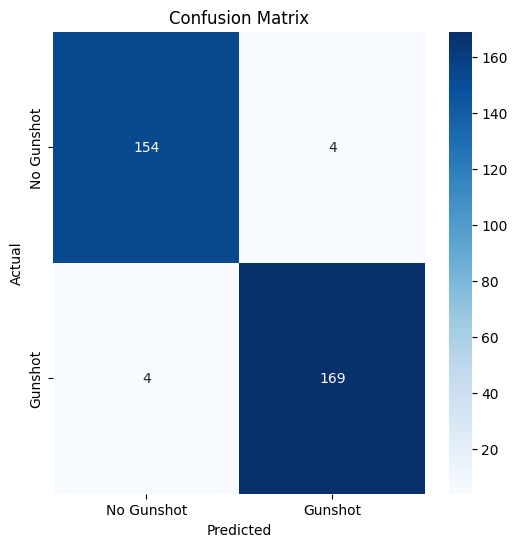

              precision    recall  f1-score   support

  No Gunshot       0.97      0.97      0.97       158
     Gunshot       0.98      0.98      0.98       173

    accuracy                           0.98       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.98      0.98      0.98       331



In [23]:
#GENERATE 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Gunshot', 'Gunshot'], yticklabels=['No Gunshot', 'Gunshot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=['No Gunshot', 'Gunshot']))


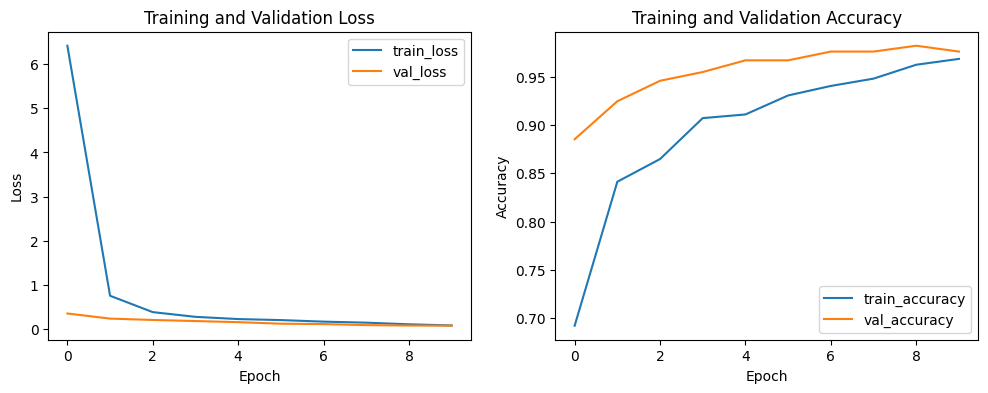

In [14]:
# Function to plot training history
def plot_training_history(history):
    # Plotting loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

# Call the function
plot_training_history(history)


In [15]:
import os
import random
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio, display

# Function to test the model on multiple random audio clips
def test_random_audio_clips(model, gunshot_folder, no_gunshot_folder, num_clips=3):
    # Ensure at least one clip from each category
    categories = ['gunshot', 'no_gunshot']
    selected_files = []
    
    # Select one clip from each category first
    for category in categories:
        folder = gunshot_folder if category == 'gunshot' else no_gunshot_folder
        audio_files = os.listdir(folder)
        random_audio_file = random.choice(audio_files)
        selected_files.append((os.path.join(folder, random_audio_file), category))
    
    # Randomly select remaining clips
    remaining_clips = num_clips - len(categories)
    for _ in range(remaining_clips):
        random_category = random.choice(categories)
        folder = gunshot_folder if random_category == 'gunshot' else no_gunshot_folder
        audio_files = os.listdir(folder)
        random_audio_file = random.choice(audio_files)
        selected_files.append((os.path.join(folder, random_audio_file), random_category))
    
    # Test the selected clips
    for audio_path, actual_category in selected_files:
        y, sr = librosa.load(audio_path, sr=None)
        display(Audio(y, rate=sr))

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs = mfccs.T  # Transpose to match the input shape (time_steps, features)
        mfccs = np.expand_dims(mfccs, axis=-1)
        mfccs = np.expand_dims(mfccs, axis=0)

        prediction = model.predict(mfccs)
        predicted_class = 'gunshot' if prediction > 0.5 else 'no_gunshot'

        print(f'Actual Category: {actual_category}')
        print(f'Predicted Category: {predicted_class}')

# Test the model on multiple random audio clips
test_random_audio_clips(model, gunshot_folder, no_gunshot_folder, num_clips=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Actual Category: gunshot
Predicted Category: gunshot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Actual Category: no_gunshot
Predicted Category: no_gunshot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Actual Category: no_gunshot
Predicted Category: no_gunshot
